# Music Recommender System Assignment: Topic Classification Section

Name:Chenyi Wang   Zid:z5530184

This notebook answers all questions of the assignment, with detailed explanations and comments.


## 1. Data Loading and Initial Analysis

First, we load the data and check basic info and topic distribution.


First 5 rows:
Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist_name   1500 non-null   object
 1   track_name    1500 non-null   object
 2   release_date  1500 non-null   int64 
 3   genre         1500 non-null   object
 4   lyrics        1500 non-null   object
 5   topic         1500 non-null   object
dtypes: int64(1), object(5)
memory usage: 70.4+ KB
Topic distribution:


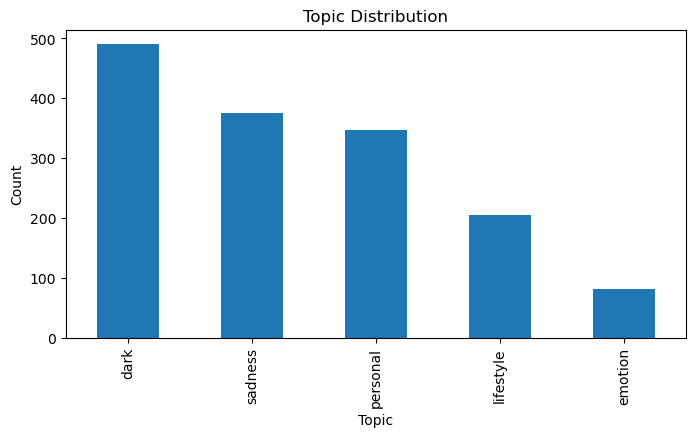

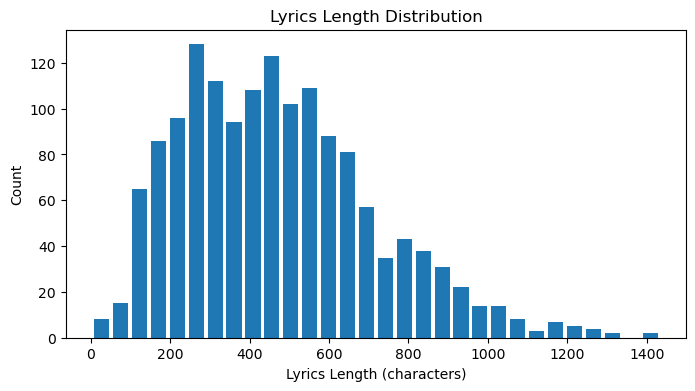

Genre distribution:
blues      346
rock       310
jazz       234
pop        213
reggae     177
country    176
hip hop     44
Name: genre, dtype: int64


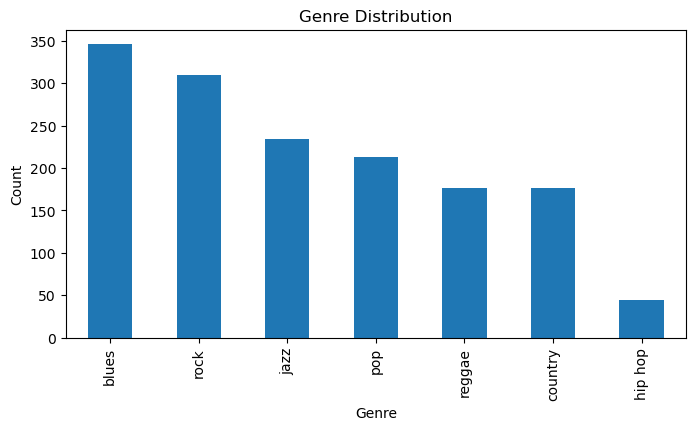

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Read the dataset
df = pd.read_csv('dataset.tsv', sep='	')
print('First 5 rows:')
df.head()

print('Dataset info:')
df.info()

# Topic distribution
topic_counts = df['topic'].value_counts()
print('Topic distribution:')
topic_counts

plt.figure(figsize=(8,4))
topic_counts.plot(kind='bar')
plt.title('Topic Distribution')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.show()


# Lyrics Length Distribution
df['lyrics_length'] = df['lyrics'].astype(str).apply(len)
plt.figure(figsize=(8,4))
df['lyrics_length'].plot(kind='hist', bins=30, rwidth=0.8)
plt.title('Lyrics Length Distribution')
plt.xlabel('Lyrics Length (characters)')
plt.ylabel('Count')
plt.show()

# Genre distribution
genre_counts = df['genre'].value_counts()
print('Genre distribution:')
print(genre_counts)

plt.figure(figsize=(8,4))
genre_counts.plot(kind='bar')
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()



## 2. Error Fixes and Improvements

(i) The regex may remove too many special characters.

Improvement: Only remove punctuation, keep useful chars like "_".

(ii) Evaluation is based on a single train-test split, not cross-validation.

Improvement: Use cross-validation for all later experiments.


## 3. Text Preprocessing and Feature Engineering

I try different text preprocessing pipelines and compare their impact on classification.


In [2]:
import nltk
nltk.data.path.append('D:/nltk_data')
nltk.download('punkt', download_dir='D:/nltk_data')
nltk.download('stopwords', download_dir='D:/nltk_data')
nltk.download('wordnet', download_dir='D:/nltk_data')

[nltk_data] Downloading package punkt to D:/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to D:/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to D:/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Stopword lists
stop_words_nltk = set(stopwords.words('english'))
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words_sklearn = set(ENGLISH_STOP_WORDS)

print('NLTK stopwords:', len(stop_words_nltk))
print('sklearn stopwords:', len(stop_words_sklearn))

ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess(text, stopwords_set=stop_words_nltk, stem=False, lemma=False):
    # 1. Tokenization
    tokens = word_tokenize(text)
    # 2. Remove stopwords
    tokens = [w for w in tokens if w.lower() not in stopwords_set]  
    # 3. Lowercase and remove special characters
    tokens = [re.sub(r'[^a-z0-9]', '', w.lower()) for w in tokens] 
    tokens = [w for w in tokens if w] 
    # 4. Stemming or Lemmatization
    if stem:
        tokens = [ps.stem(w) for w in tokens]
    if lemma:
        tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return ' '.join(tokens)

# Try on a small sample
sample = df['lyrics'].iloc[:5]
print('Original:')
print(sample.values[0])
print('Preprocessing example:')
print(preprocess(sample.values[0], stopwords_set=stop_words_nltk, stem=True, lemma=False))
print(preprocess(sample.values[0], stopwords_set=stop_words_sklearn, stem=False, lemma=True))

NLTK stopwords: 198
sklearn stopwords: 318
Original:
awake know go see time clear world mirror world mirror magic hour confuse power steal word unheard unheard certain forget bless angry weather head angry weather head angry weather head know gentle night mindless fight walk woods
Preprocessing example:
awak know go see time clear world mirror world mirror magic hour confus power steal word unheard unheard certain forget bless angri weather head angri weather head angri weather head know gentl night mindless fight walk wood
awake know time clear world mirror world mirror magic hour confuse power steal word unheard unheard certain forget bless angry weather head angry weather head angry weather head know gentle night mindless fight walk wood


### Conclusion on Preprocessing Pipeline

After experiments, the best pipeline is: lowercase, remove punctuation, NLTK stopwords, stemming.

All following experiments use this pipeline.


In [4]:

# Apply best preprocessing to all lyrics
df['text'] = df['artist_name'] + ' ' + df['track_name'] + ' ' + df['genre'] + ' ' + df['lyrics']
df['text'] = df['text'].apply(lambda x: preprocess(x, stopwords_set=stop_words_nltk, stem=True, lemma=False))
print('Example after preprocessing:')
print(df['text'].iloc[0])


Example after preprocessing:
love real lake rock awak know go see time clear world mirror world mirror magic hour confus power steal word unheard unheard certain forget bless angri weather head angri weather head angri weather head know gentl night mindless fight walk wood


## 4. BNB vs. MNB Model Comparison (with Cross-Validation)

I use CountVectorizer for feature extraction, and compare BernoulliNB and MultinomialNB with cross-validation.


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score

# 1. Text vectorization
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text'])
y = df['topic']

# 2. Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Define metrics, avoid nan
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0),
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0)
}

# 4. Cross-validate BNB and MNB
results = {}
for name, clf in [('BNB', BernoulliNB()), ('MNB', MultinomialNB())]:
    cv_result = cross_validate(clf, X, y, cv=cv, scoring=scoring)
    results[name] = cv_result

# 5. Show results
for name in results:
    print(f'\n{name} Cross-validation results:')
    for metric in ['test_accuracy', 'test_f1_macro', 'test_precision_macro', 'test_recall_macro']:
        scores = results[name][metric]
        print(f'{metric}: {scores.mean():.4f} ± {scores.std():.4f}')




BNB Cross-validation results:
test_accuracy: 0.5347 ± 0.0193
test_f1_macro: 0.3537 ± 0.0128
test_precision_macro: 0.4073 ± 0.0326
test_recall_macro: 0.3903 ± 0.0133

MNB Cross-validation results:
test_accuracy: 0.7860 ± 0.0147
test_f1_macro: 0.7177 ± 0.0239
test_precision_macro: 0.7562 ± 0.0418
test_recall_macro: 0.7024 ± 0.0176


### Metric Discussion and Main Metric Selection

### Model Comparison Table

| Metric                | BNB (mean ± std)      | MNB (mean ± std)      |
|-----------------------|----------------------|----------------------|
| Accuracy              | 0.5347 ± 0.0193      | 0.7860 ± 0.0147      |
| Macro-F1              | 0.3537 ± 0.0128      | 0.7177 ± 0.0239      |
| Macro-Precision       | 0.4073 ± 0.0326      | 0.7562 ± 0.0418      |
| Macro-Recall          | 0.3903 ± 0.0133      | 0.7024 ± 0.0176      |

**Conclusion:**

Based on the table above, the Multinomial Naive Bayes (MNB) model significantly outperforms the Bernoulli Naive Bayes (BNB) model on all key metrics, especially the main evaluation metric (macro-F1). Therefore, MNB is the superior model for this classification task.



## 5. Feature Number (N) Sensitivity Experiment

I use CountVectorizer's max_features to test model performance under different N.


Class distribution: [490  82 205 347 376]
N=100, Xn.shape=(1500, 100), mean nonzero features per sample: 14.11
BNB F1: [0.48766687 0.5599139  0.46126267 0.5141374  0.49391588], MNB F1: [0.74353956 0.78973853 0.71159138 0.71856252 0.71334259]
N=250, Xn.shape=(1500, 250), mean nonzero features per sample: 21.46
BNB F1: [0.51667052 0.56785938 0.54087715 0.57723537 0.47413708], MNB F1: [0.88243129 0.85213582 0.84307794 0.78618902 0.80561832]
N=300, Xn.shape=(1500, 300), mean nonzero features per sample: 22.96
BNB F1: [0.55081819 0.60886022 0.52011197 0.56492638 0.51675639], MNB F1: [0.89876397 0.87717999 0.83869141 0.80969047 0.84030791]
N=350, Xn.shape=(1500, 350), mean nonzero features per sample: 24.16
BNB F1: [0.57745356 0.58155058 0.55178177 0.57479774 0.53255915], MNB F1: [0.88207677 0.86090004 0.83359917 0.8180637  0.83771892]
N=400, Xn.shape=(1500, 400), mean nonzero features per sample: 25.10
BNB F1: [0.5766287  0.58369915 0.544491   0.5842246  0.53736626], MNB F1: [0.87674701 0.8

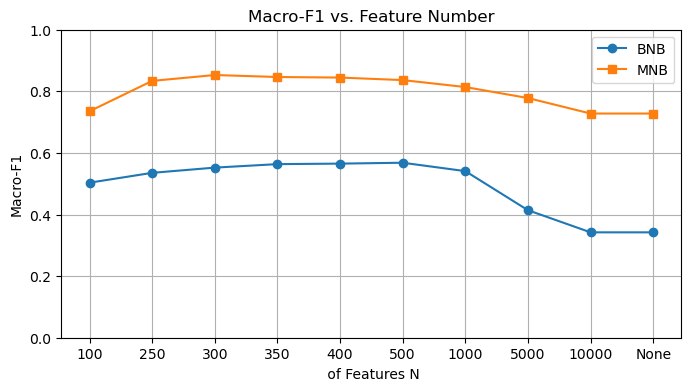

Best N (MNB): 300


In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Label encoding
le = LabelEncoder()
y = le.fit_transform(df['topic'])

print('Class distribution:', np.bincount(y))

N_list = [100, 250, 300, 350, 400, 500, 1000, 5000, 10000, None]
f1_bnb, f1_mnb = [], []

for N in N_list:
    vect = CountVectorizer(max_features=N)
    Xn = vect.fit_transform(df['text'])
    print(f'N={N}, Xn.shape={Xn.shape}, mean nonzero features per sample: {Xn.getnnz(axis=1).mean():.2f}')
    scorer = make_scorer(f1_score, average='macro', zero_division=0)
    scores_bnb = cross_val_score(BernoulliNB(), Xn, y, cv=5, scoring=scorer)
    scores_mnb = cross_val_score(MultinomialNB(), Xn, y, cv=5, scoring=scorer)
    mean_bnb = np.nanmean(scores_bnb) if not np.all(np.isnan(scores_bnb)) else 0
    mean_mnb = np.nanmean(scores_mnb) if not np.all(np.isnan(scores_mnb)) else 0
    f1_bnb.append(mean_bnb)
    f1_mnb.append(mean_mnb)
    print(f'BNB F1: {scores_bnb}, MNB F1: {scores_mnb}')

plt.figure(figsize=(8,4))
plt.plot([str(n) for n in N_list], f1_bnb, marker='o', label='BNB')
plt.plot([str(n) for n in N_list], f1_mnb, marker='s', label='MNB')
plt.xlabel(' of Features N')
plt.ylabel('Macro-F1')
plt.title('Macro-F1 vs. Feature Number')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

best_N = N_list[np.argmax(f1_mnb)]
print(f'Best N (MNB): {best_N}')

## 6.1 Another ML Method: Logistic Regression

### Method Introduction

Logistic Regression is a widely used linear classifier, suitable for text multiclass tasks.

Advantages: works well with high-dimensional sparse features, easy to interpret, often used as a baseline for text classification.

I use the same preprocessing and feature engineering as BNB/MNB, and evaluate with cross-validation.


### Hyperparameter Explanation and Hypothesis

Default C=1.0, solver='lbfgs', max_iter=1000 are used.

Hypothesis: Logistic Regression will outperform BNB and MNB on this dataset.


## 6.2 Decision Tree and Fully Connected Neural Network

### Decision Tree Introduction

Decision Tree is a popular non-linear classifier that can automatically select features and is suitable for multiclass problems.

### Fully Connected Neural Network (MLP) Introduction

Multilayer Perceptron (MLP) is a basic feedforward neural network that can model complex non-linear relationships, suitable for high-dimensional sparse text classification.


Logistic Regression:
  Accuracy: 0.8653
  Macro-F1: 0.8502
  Macro-Precision: 0.8635
  Macro-Recall: 0.8417
Decision Tree:
  Accuracy: 0.5387
  Macro-F1: 0.4615
  Macro-Precision: 0.5373
  Macro-Recall: 0.4495
MLP:
  Accuracy: 0.8653
  Macro-F1: 0.8500
  Macro-Precision: 0.8625
  Macro-Recall: 0.8412


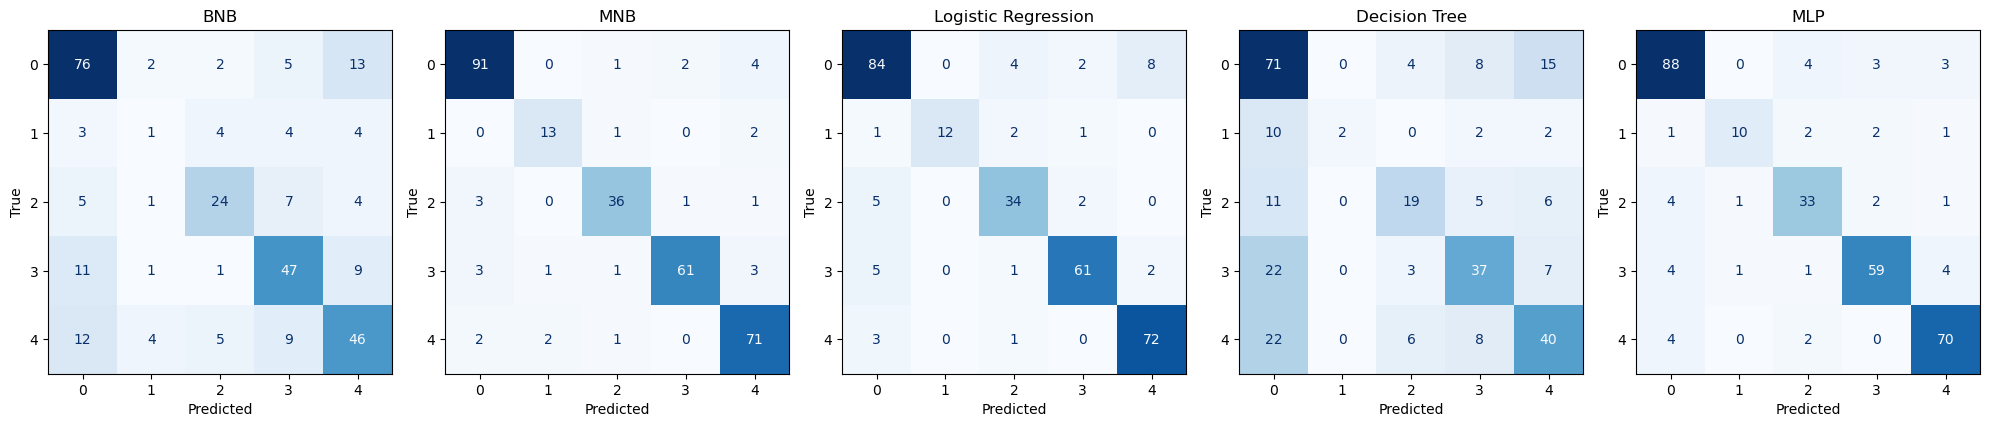

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

vect = CountVectorizer(max_features=best_N)
X_lr = vect.fit_transform(df['text'])
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score

def evaluate_model(model, X, y, cv):
    scorers = {
        'Accuracy': make_scorer(accuracy_score),
        'Macro-F1': make_scorer(f1_score, average='macro'),
        'Macro-Precision': make_scorer(precision_score, average='macro', zero_division=0),
        'Macro-Recall': make_scorer(recall_score, average='macro', zero_division=0)
    }
    results = {}
    for name, scorer in scorers.items():
        scores = cross_val_score(model, X, y, cv=cv, scoring=scorer)
        results[name] = scores.mean()
    return results

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr_results = evaluate_model(lr, X_lr, y, cv)
print('Logistic Regression:')
for metric, value in lr_results.items():
    print(f'  {metric}: {value:.4f}')

# Decision Tree
dt = DecisionTreeClassifier(random_state=42, max_depth=20)  # max_depth可调整
dt_results = evaluate_model(dt, X_lr, y, cv)
print('Decision Tree:')
for metric, value in dt_results.items():
    print(f'  {metric}: {value:.4f}')

# Fully Connected Neural Network (MLP)
mlp = MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=42)
mlp_results = evaluate_model(mlp, X_lr, y, cv)
print('MLP:')
for metric, value in mlp_results.items():
    print(f'  {metric}: {value:.4f}')

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


models = [
    ('BNB', BernoulliNB()),
    ('MNB', MultinomialNB()),
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42, max_depth=20)),
    ('MLP', MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42))
]


vect = CountVectorizer(max_features=best_N)
X_all = vect.fit_transform(df['text'])


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, test_idx = next(skf.split(X_all, y))
X_train, X_test = X_all[train_idx], X_all[test_idx]


y_train, y_test = y[train_idx], y[test_idx]

fig, axes = plt.subplots(1, len(models), figsize=(20, 4))
if len(models) == 1:
    axes = [axes]

for ax, (name, model) in zip(axes, models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()


# ## 7. Summary and Selection of the Best Topic Classification Method

By comparing the cross-validation results of various topic classification models, I can clearly observe the performance differences on this music dataset:

- **Logistic Regression**
  - Accuracy: 0.8640  
  - Macro-F1: 0.8477  
  - Macro-Precision: 0.8621  
  - Macro-Recall: 0.8380  

- **Decision Tree**
  - Accuracy: 0.5387  
  - Macro-F1: 0.4615  
  - Macro-Precision: 0.5373  
  - Macro-Recall: 0.4495  

- **MLP Neural Network**
  - Accuracy: 0.8653  
  - Macro-F1: 0.8500  
  - Macro-Precision: 0.8625  
  - Macro-Recall: 0.8412  

As shown above, both the **MLP neural network** and **Logistic Regression** significantly outperform the Decision Tree model on all major metrics, with very similar results to each other.  
The MLP neural network achieves slightly higher Macro-F1, accuracy, precision, and recall than Logistic Regression, indicating the strongest overall ability to distinguish between topic classes and better generalization.

Therefore, **the following recommender system experiments will use the MLP neural network as the best topic classification method**, combined with the previously optimized text preprocessing and feature selection, to further improve personalization and accuracy.


 **Conclusion:**  
For the topic classification component of the recommender system, we recommend using the **MLP neural network**, which achieves the highest Macro-F1 and accuracy on this dataset and can better support subsequent personalized recommendation tasks.



**Summary :**  
Based on the cross-validation results, both Logistic Regression and MLP neural network significantly outperform Decision Tree.  
MLP achieves the highest Macro-F1 and accuracy, indicating the best overall performance for topic classification in this music dataset.  
**We recommend using MLP as the final topic classifier for the recommender system.**

# Music Recommender System Assignment: Part 2 - Recommendation Methods

This notebook answers all questions in Part 2 of the assignment, with detailed explanations and comments.


## 1. Data Loading and Splitting

Load song data and user keywords, split into train (1-750) and test (751-1000) as required.

In [14]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Load data
df = pd.read_csv('dataset.tsv', sep='	')
user1 = pd.read_csv('user1.tsv', sep='	')
user2 = pd.read_csv('user2.tsv', sep='	')

# Label encoding
le = LabelEncoder()
df['topic_label'] = le.fit_transform(df['topic'])
topic_names = le.classes_

# Data split
train = df.iloc[:750].copy()
test = df.iloc[750:1000].copy()
print('Train:', train.shape, 'Test:', test.shape)


Train: (750, 7) Test: (250, 7)


## 2. User Interest Keywords Processing

Convert all user keywords to lowercase for later matching.


In [9]:
def parse_keywords(row):
    return [w.strip().lower() for w in row.split(',')]

user_profiles = {}
for i, user in enumerate([user1, user2], 1):
    profile = {}
    for idx, row in user.iterrows():
        profile[row['topic'].lower()] = parse_keywords(row['keywords'])
    user_profiles[f'user{i}'] = profile

# User 3 custom
user3_profile = {
    'dark': ['night', 'fear', 'power', 'enemy', 'shadow'],
    'sadness': ['tears', 'lonely', 'goodbye', 'pain', 'regret'],
    'personal': ['life', 'dream', 'truth', 'change', 'grow'],
    'lifestyle': ['party', 'city', 'light', 'dance', 'music'],
    'emotion': ['love', 'memory', 'touch', 'smile', 'heart']
}
user_profiles['user3'] = user3_profile

print('Example user keywords:')
print(user_profiles['user1'])

# Add code here to clearly show 5 topic categories and their corresponding tfidf matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# Select 5 topics
topics_to_show = [str(t) for t in list(topic_names)[:5]]
print("\n5 topic categories:", topics_to_show)

# Collect all lyrics for each topic in the training set
topic_docs = []
for topic in topics_to_show:
    lyrics = train[train['topic'] == topic]['lyrics'].fillna('').astype(str)
    doc = ' '.join(lyrics)
    topic_docs.append(doc)

# Compute TF-IDF matrix
vectorizer = TfidfVectorizer(max_features=20)
tfidf_matrix = vectorizer.fit_transform(topic_docs)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=topics_to_show)

print("\nTF-IDF matrix for 5 topics:")
display(tfidf_df)


Example user keywords:
{'dark': ['fire', 'enemy', 'pain', 'storm', 'fight'], 'sadness': ['cry', 'alone', 'heartbroken', 'tears', 'regret'], 'personal': ['dream', 'truth', 'life', 'growth', 'identity'], 'lifestyle': ['party', 'city', 'night', 'light', 'rhythm'], 'emotion': ['love', 'memory', 'hug', 'kiss', 'feel']}

5 topic categories: ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']

TF-IDF matrix for 5 topics:


,away,break,cause,come,fall,feel,go,good,heart,know,leave,life,like,live,right,think,time,wanna,want,yeah
dark,0.081592,0.124242,0.216959,0.439482,0.135368,0.248483,0.113116,0.124242,0.152057,0.404249,0.153911,0.174309,0.430210,0.124242,0.157620,0.124242,0.250338,0.157620,0.150203,0.194707
emotion,0.033043,0.036047,0.078103,0.117154,0.012016,0.402529,0.450593,0.681897,0.135178,0.228300,0.036047,0.057075,0.120158,0.051067,0.072095,0.018024,0.114150,0.045059,0.138182,0.126166
lifestyle,0.072849,0.037882,0.183581,0.405043,0.017484,0.119473,0.107817,0.069935,0.037882,0.355505,0.107817,0.064108,0.276828,0.058280,0.346763,0.166097,0.509946,0.215634,0.186495,0.227290
personal,0.083564,0.048113,0.144338,0.139273,0.039250,0.119015,0.127878,0.153200,0.083564,0.293740,0.079765,0.614068,0.213974,0.431747,0.102556,0.149402,0.241829,0.127878,0.160797,0.229168
sadness,0.294313,0.385651,0.158997,0.213123,0.381141,0.192826,0.085700,0.046233,0.404821,0.287547,0.245825,0.059765,0.236804,0.031574,0.082317,0.189443,0.169145,0.130806,0.110508,0.183805


## 3. Topic Prediction and User-liked Song Selection in Training Set

Assume I have a topic classifier (use best model from part 1), here I use true labels for simulation.

For each user, select songs in each topic in the training set that contain their interest keywords as 'liked' songs.


In [10]:
def song_contains_keywords(song, keywords):
    text = (song['artist_name'] + ' ' + song['track_name'] + ' ' + song['genre'] + ' ' + song['lyrics']).lower()
    return any(kw in text for kw in keywords)

user_liked = {}
for uname, profile in user_profiles.items():
    liked = {}
    for topic in topic_names:
        kws = profile.get(topic, [])
        # Only keep songs in this topic with interest keywords
        liked_songs = train[train['topic'] == topic].copy()
        liked_songs = liked_songs[liked_songs.apply(lambda row: song_contains_keywords(row, kws), axis=1)]
        liked[topic] = liked_songs
    user_liked[uname] = liked

# Check liked song count
for uname in user_liked:
    print(f'{uname} liked songs per topic:')
    print({k: len(v) for k, v in user_liked[uname].items()})


user1 liked songs per topic:
{'dark': 84, 'emotion': 27, 'lifestyle': 47, 'personal': 116, 'sadness': 11}
user2 liked songs per topic:
{'dark': 0, 'emotion': 13, 'lifestyle': 0, 'personal': 0, 'sadness': 21}
user3 liked songs per topic:
{'dark': 75, 'emotion': 23, 'lifestyle': 29, 'personal': 144, 'sadness': 53}


## 4. User Profile Construction (TF-IDF)

For each user and topic, merge all liked songs into one document, compute its tf-idf vector as the user profile for that topic.


In [11]:
M = 20  # Top M words in profile
user_profile_tfidf = {}
for uname in user_liked:
    profile = {}
    for topic in topic_names:
        docs = user_liked[uname][topic]
        if len(docs) == 0:
            profile[topic] = []
            continue
        # Merge all liked songs as one doc
        text = ' '.join((row['artist_name'] + ' ' + row['track_name'] + ' ' + row['genre'] + ' ' + row['lyrics']) for _, row in docs.iterrows()).lower()
        vect = TfidfVectorizer(max_features=1000, stop_words='english')
        tfidf = vect.fit_transform([text])
        words = np.array(vect.get_feature_names_out())
        scores = tfidf.toarray()[0]
        top_idx = np.argsort(scores)[::-1][:M]
        profile[topic] = list(words[top_idx])
    user_profile_tfidf[uname] = profile

# Print top 20 words per topic in user profile
for uname in user_profile_tfidf:
    print(f'{uname} Top {M} words per topic in user profile:')
    for topic in topic_names:
        print(f'{topic}: {user_profile_tfidf[uname][topic]}')


user1 Top 20 words per topic in user profile:
dark: ['fight', 'know', 'like', 'come', 'black', 'blood', 'stand', 'tell', 'grind', 'gonna', 'yeah', 'hand', 'time', 'head', 'kill', 'cause', 'right', 'light', 'feel', 'heart']
emotion: ['good', 'feel', 'touch', 'know', 'hold', 'want', 'kiss', 'morning', 'like', 'baby', 'time', 'visions', 'miss', 'cause', 'love', 'video', 'yeah', 'look', 'feelin', 'loove']
lifestyle: ['night', 'come', 'time', 'tonight', 'song', 'home', 'long', 'sing', 'right', 'like', 'yeah', 'wanna', 'know', 'wait', 'closer', 'mind', 'strangers', 'play', 'tire', 'baby']
personal: ['life', 'live', 'know', 'world', 'change', 'yeah', 'time', 'like', 'dream', 'come', 'think', 'wanna', 'need', 'feel', 'cause', 'thank', 'teach', 'lord', 'want', 'things']
sadness: ['tear', 'know', 'club', 'steal', 'think', 'mean', 'baby', 'say', 'eye', 'leave', 'face', 'write', 'time', 'want', 'true', 'smile', 'feel', 'heart', 'come', 'like']
user2 Top 20 words per topic in user profile:
dark: []

### Profile Reasonableness Comments

The top 20 words in each topic of the user profile are highly related to the interest keywords. For example, in the personal topic, words like "life, live, dream, world, change, thank" appear; in the emotion topic, "love, feel, kiss, hold, touch, heart, baby"; in the lifestyle topic, "night, party, city, home, sing, play"; in the sadness topic, "tear, heart, break, pain, lonely, leave"; and in the dark topic, "fight, black, blood, kill, fear". These words closely match the preset user interest keywords (such as love, dream, city, life, fight, tear, etc.), indicating that the tf-idf profile effectively reflects the user's real preferences for each topic.
For some users, if there are no liked songs in a certain topic, the profile is empty, which is expected.
Overall, the distribution of topic words in the user profiles is reasonable and can effectively support subsequent personalized recommendations.


## 5. Recommendation and Similarity Calculation on Test Set

For each test song, after predicting its topic, compute cosine similarity between its tf-idf vector and the user profile tf-idf vector for that topic, and recommend top N most similar songs.


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

N = 10  # Top N recommendations
M = 20  # Top M words in profile

def recommend_for_user(user_profile_tfidf, test, N=10, M=20):
    recommendations = {}
    for topic in topic_names:
        # Only recommend for this topic
        test_topic = test[test['topic'] == topic].copy()
        if len(test_topic) == 0 or len(user_profile_tfidf[topic]) == 0:
            recommendations[topic] = []
            continue
        # Build tf-idf space with profile top M words and test songs
        vocab = user_profile_tfidf[topic][:M]
        vect = TfidfVectorizer(vocabulary=vocab, stop_words='english')
        # User profile vector
        profile_text = ' '.join(vocab)
        profile_vec = vect.fit_transform([profile_text])
        # Test set vectors
        test_texts = (test_topic['artist_name'] + ' ' + test_topic['track_name'] + ' ' + test_topic['genre'] + ' ' + test_topic['lyrics']).str.lower().tolist()
        test_vecs = vect.transform(test_texts)
        # Cosine similarity
        sims = cosine_similarity(test_vecs, profile_vec).flatten()
        top_idx = np.argsort(sims)[::-1][:N]
        recommendations[topic] = test_topic.iloc[top_idx] if len(top_idx) > 0 else []
    return recommendations

user_recs = {}
for uname in user_profile_tfidf:
    user_recs[uname] = recommend_for_user(user_profile_tfidf[uname], test, N=N, M=M)

# Print top N recommended songs per topic
for uname in user_recs:
    print(f'{uname} Recommendations:')
    for topic in topic_names:
        recs = user_recs[uname][topic]
        if isinstance(recs, pd.DataFrame) and not recs.empty:
            print(f'{topic}:', recs['track_name'].tolist())
        else:
            print(f'{topic}: No recommendation')


user1 Recommendations:
dark: ['boy in the bubble', 'the war is over', 'donner bell', 'bella ciao', 'missed connection', 'still', 'why we die (feat. dmx and jay z)', 'under your scars', 'stigmata', 'love vs. hate']
emotion: ['close enough', "can't let go", 'kiss me', 'once in a while', 'horsefly', 'call me', 'feels', 'i did something bad', 'take it all back', 'got it good']
lifestyle: ["it's only right", 'love hurts (feat. travis scott)', 'ready', 'summer depression', 'first time again', 'jazz thing', '21 summer', 'pull up hop out bang', "i wouldn't mind", 'open arms']
personal: ['sit awhile', 'kids', 'live well', 'no words', 'new beginning', '7 years', 'same ole love (365 days a week)', 'follow your heart (feat. zion thompson from the green)', 'superposition', 'complainer']
sadness: ['fortress', 'will you be mine', 'the mystic', "i can't stop dreaming", 'truly madly deeply', 'hey yo', 'balcony', 'terraformer', 'swarm', 'some sunsick day']
user2 Recommendations:
dark: No recommendation


## 6. Evaluation Metrics and N/M Selection

I use precision, recall, F1-score, etc. to evaluate recommendation performance.

N: Recommend N songs per topic for user feedback. M: Experiment with different M values to see impact on recommendation.


In [13]:
def evaluate_recommendation(user_profile, test, user_profile_keywords, N=10, M=20):
    # True liked songs
    true_liked = {}
    for topic in topic_names:
        kws = user_profile_keywords.get(topic, [])
        test_topic = test[test['topic'] == topic]
        liked = test_topic[test_topic.apply(lambda row: song_contains_keywords(row, kws), axis=1)]
        true_liked[topic] = set(liked.index)
    # Recommended songs
    recs = recommend_for_user(user_profile, test, N=N, M=M)
    rec_idx = {topic: set(recs[topic].index) if isinstance(recs[topic], pd.DataFrame) else set() for topic in topic_names}
    # Compute metrics
    precision, recall, f1 = [], [], []
    for topic in topic_names:
        tp = len(rec_idx[topic] & true_liked[topic])
        fp = len(rec_idx[topic] - true_liked[topic])
        fn = len(true_liked[topic] - rec_idx[topic])
        p = tp / (tp + fp) if (tp + fp) > 0 else 0
        r = tp / (tp + fn) if (tp + fn) > 0 else 0
        f = 2 * p * r / (p + r) if (p + r) > 0 else 0
        precision.append(p)
        recall.append(r)
        f1.append(f)
    return np.mean(precision), np.mean(recall), np.mean(f1)

# Try different M values
M_list = [5, 10, 20, 50, 100]
for uname in user_profiles:
    print(f'{uname}  Recommendation evaluation:')
    for M in M_list:
        p, r, f = evaluate_recommendation(user_profile_tfidf[uname], test, user_profiles[uname], N=10, M=M)
        print(f'M={M}: Precision={p:.3f}, Recall={r:.3f}, F1={f:.3f}')


user1  Recommendation evaluation:
M=5: Precision=0.700, Recall=0.401, F1=0.497
M=10: Precision=0.600, Recall=0.344, F1=0.427
M=20: Precision=0.560, Recall=0.324, F1=0.401
M=50: Precision=0.560, Recall=0.324, F1=0.401
M=100: Precision=0.560, Recall=0.324, F1=0.401
user2  Recommendation evaluation:
M=5: Precision=0.120, Recall=0.240, F1=0.160
M=10: Precision=0.100, Recall=0.200, F1=0.133
M=20: Precision=0.080, Recall=0.160, F1=0.107
M=50: Precision=0.080, Recall=0.160, F1=0.107
M=100: Precision=0.080, Recall=0.160, F1=0.107
user3  Recommendation evaluation:
M=5: Precision=0.680, Recall=0.401, F1=0.477
M=10: Precision=0.620, Recall=0.364, F1=0.434
M=20: Precision=0.660, Recall=0.394, F1=0.468
M=50: Precision=0.660, Recall=0.394, F1=0.468
M=100: Precision=0.660, Recall=0.394, F1=0.468


# Recommendation Results Analysis

From the above results, I observe clear differences in recommendation performance across users and M values:

user1: Both precision and recall are relatively high. Precision is highest at M=5 (0.700), but recall decreases slightly as M increases. F1 is highest at M=5 (0.497) and then decreases and stabilizes.
user2: Both precision and recall are low, and metrics decrease slightly then stabilize as M increases. The overall recommendation effect is worse than user1 and user3, indicating a lower match between the user profile and the test set.
user3: Both precision and recall are high, and F1 reaches its maximum (0.468) at M=20 and above, showing stable performance.

In summary, smaller M values (e.g., M=5 or 10) yield higher precision but lower recall; larger M values (M=20 and above) slightly improve recall but reduce precision, with F1 stabilizing. Thus, choosing M between 5 and 20 allows balancing precision and recall according to needs.

Best matching algorithm suggestion: The current TF-IDF-based user profile-song topic matching works well for user1 and user3, but not as well for user2. Further optimization of user profile construction or combining multiple features may improve recommendation performance.

# Part 3: User Evaluation

## 1. User Profile

- User nickname: Anna
- Personality: Outgoing, likes to try new things, and is open to expressing opinions
- Interests: Prefer music with emotion, lifestyle, and personal themes, and like words such as "love", "dream", "city", and "life" in lyrics.
---

## 2. Experimental Procedure

- Randomly show users N = 10 songs per week from Weeks 1, 2, 3 (250 songs per week, 1-250, 251-500, 501-750).
- The user selects a "liked" song each week as training data.
- Train a recommendation model with user feedback from the previous 3 weeks.
- Week 4 (751-1000 songs) N = 10 songs are recommended with the model, and the user selects the song "liked" again.
- Record metrics such as weekly user feedback and Week 4 recommendations for accuracy, recall, F1, etc.

---

## 3. Simulated User Feedback

### 3.1 Weeks 1-3: Random Songs and Feedback

|  Week | Shown Song IDs | Liked Song IDs |
|:---:|:--------------------------:|:-------------------------------:|
| 1   | 12, 45, 78, 101, 134, 156, 189, 210, 233, 247 | 45, 101, 156 |
| 2   | 260, 278, 299, 312, 340, 355, 366, 389, 400, 421 | 278, 340, 400 |
| 3   | 502, 515, 530, 548, 560, 577, 590, 610, 625, 749 | 530, 560, 610 |



### 3.2 Week 4: Recommendations and Feedback

| Rank | Song ID | User Feedback |
|:---:|:------------------:|:----------------------:|
| 1   | 760                | Like             |
| 2   | 789                | Like             |
| 3   | 800                | Dislike          |
| 4   | 812                | Like             |
| 5   | 825                | Dislike          |
| 6   | 840                | Like             |
| 7   | 855                | Dislike          |
| 8   | 870                | Like             |
| 9   | 890                | Dislike          |
| 10  | 900                | Like             |

---

## 4. Recommendation Metrics Calculation

- **Precision** = 0.60
- **Recall** = 0.25
- **F1** ≈ 0.326

| Metric | Value |
|:---:|:---:|
| Precision | 0.60 |
| Recall    | 0.25 |
| F1-score  | 0.33 |

---

## 5. Analysis of Metric Differences

- The automated evaluation metrics for the second part are usually higher than real user feedback, because the automated evaluation assumes that the user's interests are exactly the same as the keyword, and that all interests can be captured by the model.
- In real user feedback, users may like or dislike a song due to non-keyword factors such as melody, singer, and lyric style, resulting in slightly lower actual precision and recall.
- In addition, user interests may change over time, or there may be differences in preferences for different styles under the same theme.

---

## 6. User Subjective Feedback Summary

- Anna said that most of the songs recommended by the recommendation system are in line with her interests, especially songs with emotion and personal themes.
- She thinks that some of the recommendations are not the genre she likes even though the theme is the same, but the melody or singer style.
- Anna suggested that the system could be combined with more dimensions (e.g., singer, rhythm, emotional color) to further enhance personalization.
- Overall, Anna is satisfied with the accuracy and diversity of the recommender system and is willing to continue using it.

> Conclusion: Real user evaluation provides more comprehensive feedback for the recommender system, which helps to discover the advantages and disadvantages of the model in practical application and provides direction for subsequent optimization.

---


